# 3 Predictive Analytics: 
Future demand is a key factor that will steer operational decision making of a shared rental network. As a data scientist it is your responsibility to facilitate this type of decision support. For the purpose of this assignment we will be interested in **forecasting total system-level demand in the next hour**. To do so, develop a prediction model that **predicts bike rental demand as a function of suitable features available in or derived from the datasets (incl. the weather data).**

1. Feature Engineering: **Develop a rich set of features that you expect to be correlated with your target**. In this process you can draw on your domain knowledge and/or conduct additional research around the topic of demand prediction in vehicle rental networks. Justify your selection of features.

2. Model Building: Select **three regression algorithms** that are suitable for the prediction task at hand. **Explain and justify** why you selected the three algorithms and describe their respective advantages and drawbacks.

3. Model Evaluation: **How well do the models perform? Evaluate and benchmark your models’ performance using suitable evaluation metrics. Which model would you select for deployment?**

4. Outlook: How could the selected model be improved further? Explain some of the improvement levers that you might focus on in a follow-up project.

Notes and tipps

- Make generous use of visualization techniques to clearly illustrate your findings and present them in an appealing fashion.
- Evaluate your methodology and clearly state why you have opted for a specific approach in your analysis.
- Relate your findings to the real world and interpret them for non-technical audiences (e.g. What do the coefficients in your regression model mean?, What does the achieved error mean for your model?, etc.)
- Make sure to clearly state the implications (i.e. the ”so what?”) of your findings for managers/decision makers.

## 3.1 Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline

Import of data

In [3]:
df_trips = pd.read_csv('data/boston_2017_cleaned_trips.csv')
df_weather = pd.read_csv('data/weather_2017_cleaned.csv')

## 3.2 Data Preparation

In advance of building the models suitable variables are enginered that help the prediction. 

In [4]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310760 entries, 0 to 1310759
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   start_time          1310760 non-null  object 
 1   end_time            1310760 non-null  object 
 2   start_station_id    1310760 non-null  int64  
 3   end_station_id      1310760 non-null  int64  
 4   start_station_name  1310760 non-null  object 
 5   end_station_name    1310760 non-null  object 
 6   bike_id             1310760 non-null  int64  
 7   user_type           1310760 non-null  object 
 8   start_hour          1310760 non-null  int64  
 9   weekday             1310760 non-null  int64  
 10  duration            1310760 non-null  float64
 11  month               1310760 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 120.0+ MB


Our pre-processed data already contains various information about the temporal patterns e.g. the start time furthermore the hour, weekday and month of the trips.

In [5]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   max_temp   8760 non-null   float64
 1   min_temp   8760 non-null   float64
 2   precip     8760 non-null   float64
 3   date_time  8760 non-null   object 
dtypes: float64(3), object(1)
memory usage: 273.9+ KB


In [6]:
df_trips['start_date'] = df_trips['start_time']
df_trips.set_index('start_date', inplace = True)
df_trips.index = pd.to_datetime(df_trips.index)

In [7]:
# Calculating the total amount of trips started per hour
df_trips['start_time'] = pd.to_datetime(df_trips['start_time'])
df_trips_group = df_trips.groupby(pd.Grouper(key='start_time', freq='H')).count()
df_trips_group['end_time']

start_time
2017-01-01 00:00:00    13
2017-01-01 01:00:00     7
2017-01-01 02:00:00     4
2017-01-01 03:00:00     2
2017-01-01 04:00:00     6
                       ..
2017-12-31 19:00:00     6
2017-12-31 20:00:00     5
2017-12-31 21:00:00     3
2017-12-31 22:00:00     7
2017-12-31 23:00:00     2
Freq: H, Name: end_time, Length: 8760, dtype: int64

In [8]:
hourly_demand = df_trips_group['end_time']
hourly_demand

start_time
2017-01-01 00:00:00    13
2017-01-01 01:00:00     7
2017-01-01 02:00:00     4
2017-01-01 03:00:00     2
2017-01-01 04:00:00     6
                       ..
2017-12-31 19:00:00     6
2017-12-31 20:00:00     5
2017-12-31 21:00:00     3
2017-12-31 22:00:00     7
2017-12-31 23:00:00     2
Freq: H, Name: end_time, Length: 8760, dtype: int64

In [9]:
df_weather['date_time'] = pd.to_datetime(df_weather['date_time'])
df_weather.set_index('date_time', inplace = True)

Creating the dataset with the grouped demand

In [10]:
df_pred_feat = df_weather
df_pred_feat["hourly_demand"] = hourly_demand

### Feature Engineering

In [11]:
# basic temporal features
df_pred_feat["hour"] = df_pred_feat.index.hour
df_pred_feat["weekday"] = df_pred_feat.index.weekday
df_pred_feat["month"] = df_pred_feat.index.month

In [12]:
# advances temporal features and dummy encoding
df_pred_feat['is_workday'] = df_pred_feat['weekday'].apply(lambda x: 1 if x < 5 else 0)
df_pred_feat['quarter'] = df_pred_feat['month'].apply(lambda x: x // 4)
df_pred_feat = pd.get_dummies(df_pred_feat, columns = ['quarter'])

As hour and weekday are cyclical features the sin and cos components are calculated to preserve information such as hour 23 and hour 0 being close to each other and not far.

In [13]:
df_pred_feat['hour_sin'] = np.sin(df_pred_feat.hour*(2.*np.pi/24))
df_pred_feat['hour_cos'] = np.cos(df_pred_feat.hour*(2.*np.pi/24))
# month values between 0 and 11 
df_pred_feat['month_sin'] = np.sin((df_pred_feat.month-1)*(2.*np.pi/12))
df_pred_feat['month_cos'] = np.cos((df_pred_feat.month-1)*(2.*np.pi/12))

In [14]:
#df_pred_feat.groupby('hour').sum()["hourly_demand"]
#df_pred_feat.groupby('month').sum()["hourly_demand"]

## Feature Description

The heatmap shows the correlation between the features. From this insights can be derieved which features are usefull for the prediction models.

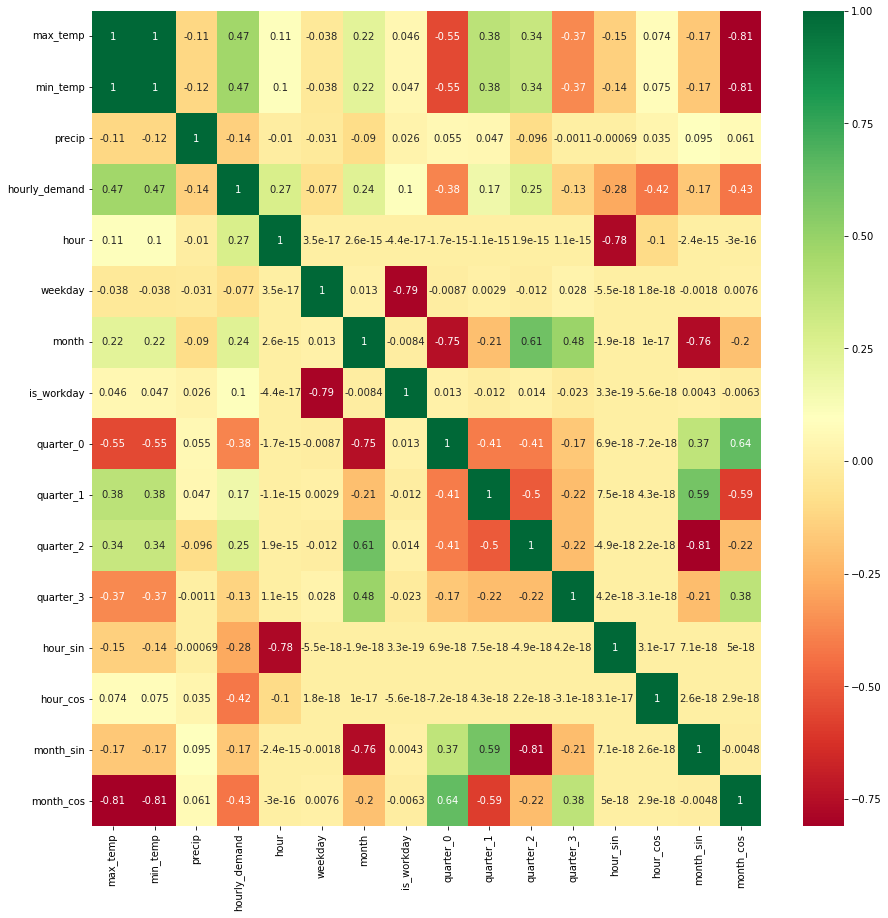

In [15]:
corrmat = df_pred_feat.corr()
top_corr_features = corrmat.index

plt.figure(figsize=(15,15))

g=sns.heatmap(df_pred_feat[top_corr_features].corr(),annot=True, cmap="RdYlGn")

## 3.3 Model Building

Now the prediciton models can be created. Starting with simple prediciton models like Linear Regression or Multipolonomial Regression. Afterwards more complex Algorithms like Random Forest, SVR, XGBoost and neural networks are created.

#### Data Splitting

In [16]:
# set outcome variable to last row
column_list = df_pred_feat.columns.tolist()
column_list.append(column_list.pop(column_list.index('hourly_demand')))
df = df_pred_feat[column_list]

# split the data with 70% in each set
train, test = train_test_split(df, test_size = 0.3)

x_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]

x_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]

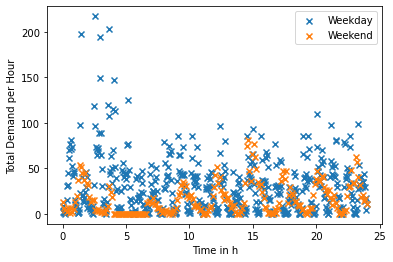

In [17]:
df_jan = df_pred_feat[list(map(lambda x : str(x)[5:7] in ["01"], df_pred_feat.index))].copy()

xt_weekday = np.linspace(0,24, num = len(df_jan[df_jan['is_workday'] == 1]))
xt_weekend = np.linspace(0,24, num = len(df_jan[df_jan['is_workday'] == 0]))

yd_weekday = df_jan[df_jan['is_workday'] == 1]['hourly_demand']
yd_weekend = df_jan[df_jan['is_workday'] == 0]['hourly_demand']

plt.scatter(xt_weekday, yd_weekday, marker = 'x', c ='C0')
plt.scatter(xt_weekend, yd_weekend, marker = 'x', c ='C1')

plt.xlabel("Time in h")
plt.ylabel("Total Demand per Hour")
plt.legend(["Weekday", "Weekend"])

In [18]:
def plot_scatter_demand (month):

    df = df_pred_feat[df_pred_feat['month'] == month].copy()

    xt_weekday = np.linspace(0,24, num = len(df[df['is_workday'] == 1]))
    xt_weekend = np.linspace(0,24, num = len(df[df['is_workday'] == 0]))

    yd_weekday = df[df['is_workday'] == 1]['hourly_demand']
    yd_weekend = df[df['is_workday'] == 0]['hourly_demand']

    plt.scatter(xt_weekday, yd_weekday, marker = 'x', c ='C0')
    plt.scatter(xt_weekend, yd_weekend, marker = 'x', c ='C1')

    plt.xlabel("Time in h")
    plt.ylabel("Total Demand per Hour")
    plt.legend(["Weekday", "Weekend"])
    plt.title("Month " + str(month))
    
    plt.show()

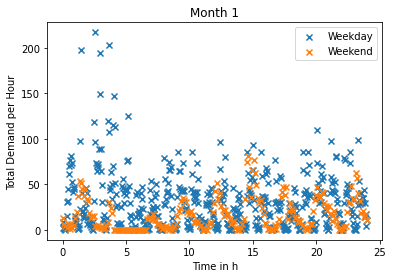

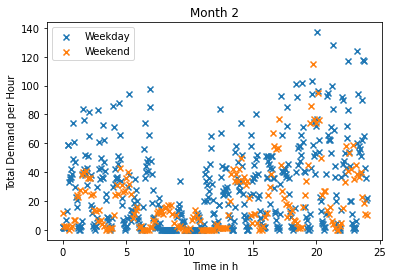

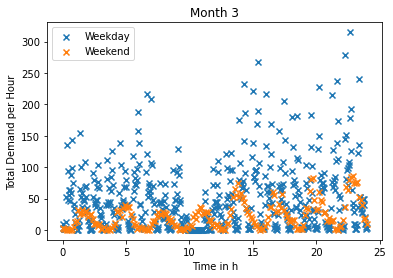

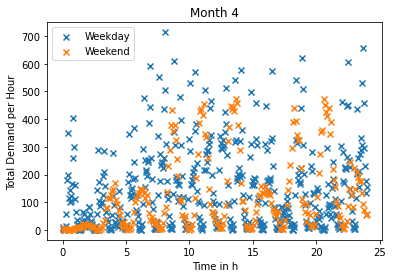

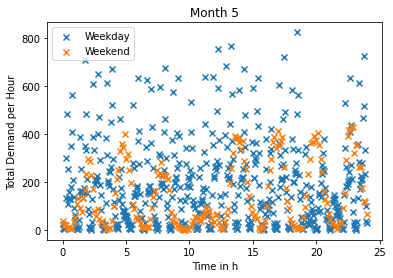

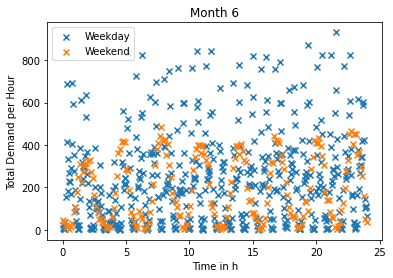

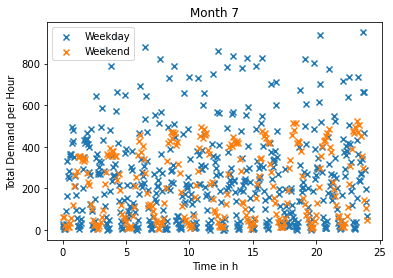

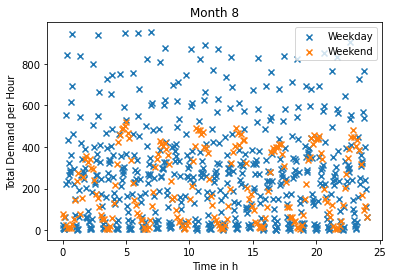

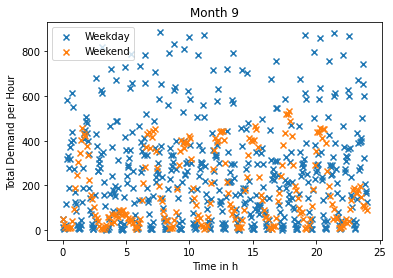

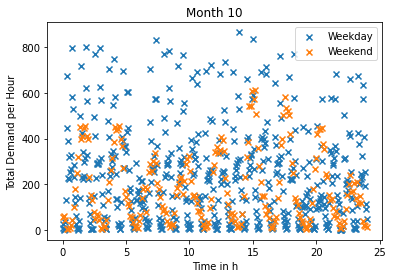

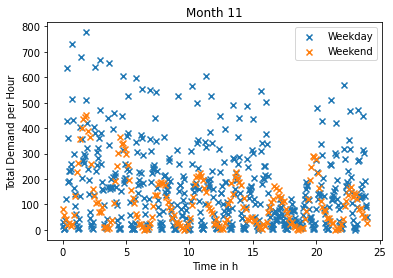

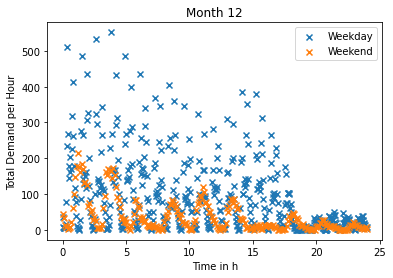

In [29]:
for i in range(1,13,1):
    plot_scatter_demand(i)

ValueError: x and y must be the same size

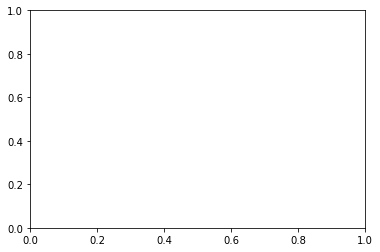

In [21]:
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_test, y_test, marker='x', color="C2")
plt.xlabel("Time in h")
plt.ylabel("Demand per Hour")
plt.legend(['Training set', 'Holdout set'])

### Fitting a regression model

In [27]:
poly_reg = PolynomialFeatures (degree = 10)
x_poly = poly_reg.fit_transform(X_train.reshape(-1,1))

model = LinearRegression(normalize = True)
model.fit(x_poly, y_train)

# evaluate the model on the second set of data
y_pred = model.predict(poly_reg.fit_transform(X_test.reshape(-1,1)))
print ('The R^2 for quadratic curve is: ',r2_score(y_test, y_pred))

plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_test, y_test, marker='x', color="C2")
plt.scatter(x_test, y_pred, marker='x', color="C1")

plt.xlabel("Time in h")
plt.ylabel("Demand per Hour")
plt.legend(['Training set', 'Holdout set'])

NameError: name 'X_train' is not defined

## XGBoost

In [ ]:
# set outcome variable to last row
column_list = df_pred_feat.columns.tolist()
column_list.append(column_list.pop(column_list.index('hourly_demand')))
df = df_pred_feat[column_list]

# split the data with 70% in each set
train, test = train_test_split(df, test_size = 0.3)

x_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]

x_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]

In [ ]:
# create a XGBoost Model with default parameters
xgbr = xgb.XGBRegressor() 

# train the model
xgbr.fit(x_train, y_train)

In [ ]:
# die beiden Kommentarzeilen habe ich irgendwo rauskopiert und 
# kein Plan was die machen 
#kfold = KFold(n_splits=10)
#results = cross_val_score(xgbr, x_train, y_train, cv=kfold)
y_test_pred = xgbr.predict(x_test)

print ('The R^2 for XGBoost is: ', r2_score(y_test, y_test_pred))
print ('The MAE for XGBoost is: ', mean_absolute_error(y_test, y_test_pred))

In [ ]:
# XGBoost with grid search for hyper paramater tuning
xgb_adv = xgb.XGBRegressor()

parameters = {'nthread':[6],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb_adv,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(x_train, y_train)

# result of the cv grid search
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
y_test_pred_grid = xgb_grid.predict(x_test)

MAE_error_grid = mean_absolute_error(y_test, y_test_pred_grid)
r2_grid = r2_score(y_test, y_test_pred_grid)

print ('The R^2 for XGBoost with grid search is: ', r2_grid)
print ('The MAE for XGBoost with grid search is: ', MAE_error_grid)

In [ ]:
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_test, y_test, marker='x', color="C2")
#plt.scatter(x_test, y_test_pred_grid, marker='x', color="C1")

plt.xlabel("Time in h")
plt.ylabel("Demand per Hour")
plt.legend(['Training set', 'Holdout set'])